## Code containing visualizations to explore the differences in coverage of conflicted entities in war news

In [ ]:
import pandas as pd
import numpy as np
import sys

from transformers import AutoModel, AutoTokenizer
import torch

pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_word_embeddings(wordlist):

    embeddings = []
    model.eval()
    for word in wordlist:
    
        tokenized_inputs = tokenizer(word, return_tensors='pt', padding=True, truncation=True).to(device)

        # Get BERT model outputs
        with torch.no_grad():
            outputs = model(**tokenized_inputs)
            
        # print(outputs.keys())

        # print("Here ", outputs.keys())
        hs = outputs.hidden_states
        emb = torch.stack([x.mean(axis = 1) for x in hs]).mean(axis = 0).detach().cpu().numpy()

        embeddings.append(np.squeeze(emb))
         
    return np.array(embeddings)

# model_name = 'answerdotai/ModernBERT-base'
model_name = 'bert-base-cased'
bert_model = AutoModel.from_pretrained(model_name, output_hidden_states = True, output_attentions = True)

device = torch.device('cuda:0')
bert_model.to(device)

# ModernBertModel
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
data = pd.read_csv('results/GazaNews_with_moral_scores.csv')

In [4]:
no_entity_mentioned_df = data[data[['pal_ent', 'hamas_ent', 'isr_ent', 'other_ent']].eq(False).all(axis = 1)]
pal_entity_mentioned_df = data[((data.pal_ent == True) & (data.hamas_ent == False) & (data.isr_ent == False) & (data.other_ent == False))]
hamas_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == True) & (data.isr_ent == False) & (data.other_ent == False))]
israel_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == False) & (data.isr_ent == True) & (data.other_ent == False))]
other_entity_mentioned_df = data[((data.pal_ent == False) & (data.hamas_ent == False) & (data.isr_ent == False) & (data.other_ent == True))]
other_entity_mentioned_df = pd.concat((no_entity_mentioned_df, other_entity_mentioned_df), axis = 0)

In [5]:
pal_entity_mentioned_df.shape, hamas_entity_mentioned_df.shape, israel_entity_mentioned_df.shape, other_entity_mentioned_df.shape

((586, 26), (517, 26), (2725, 26), (1449, 26))

In [6]:
def get_dataframe(attr):

    temp_df = pd.DataFrame()

    temp_df['entity'] = ['Palestine'] * 3 + ['Hamas'] * 3 + ['Israel'] * 3 + ['Other'] * 3
    temp_df['media'] = ['Aljazeera', 'BBC', 'Fox'] * 4

    scores = pal_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    hamas_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + israel_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist() + \
    other_entity_mentioned_df.groupby('media').mean()[f'{attr}'].tolist()

    temp_df[attr] = scores
    
    return temp_df

In [7]:
def plot(attr):
    sns.set_context(rc={'xtick.labelsize': 40, 'ytick.labelsize': 13})
    df = get_dataframe(attr)
    ax = sns.barplot(df, x="entity", y= attr, hue="media")
    ax.set_title(attr.title(), fontsize=18)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.legend().set_visible(False)
  
    plt.savefig(f"results/{attr}.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as PNG

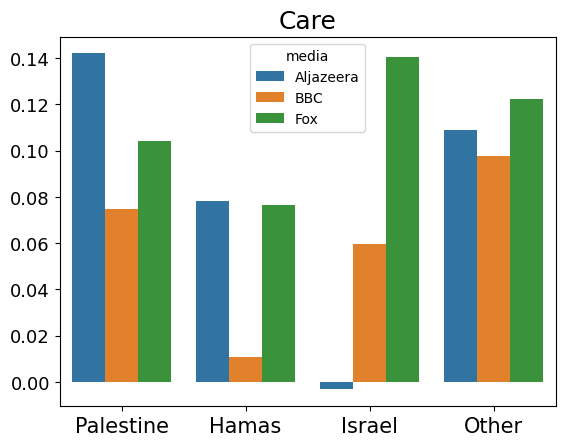

In [8]:
plot('care')

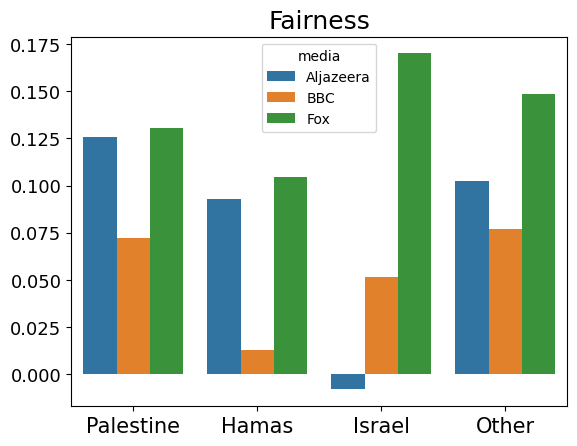

In [9]:
plot('fairness')

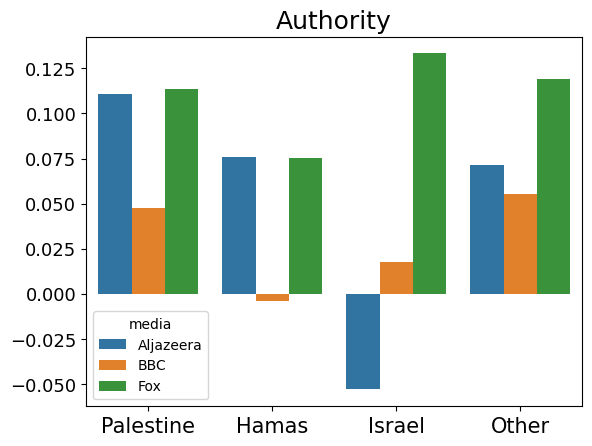

In [10]:
plot('authority')

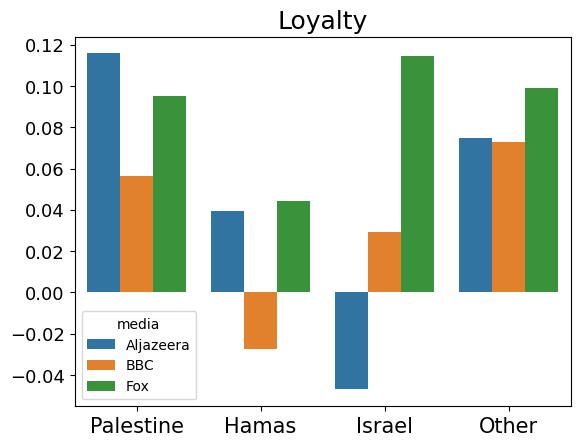

In [11]:
plot('loyalty')

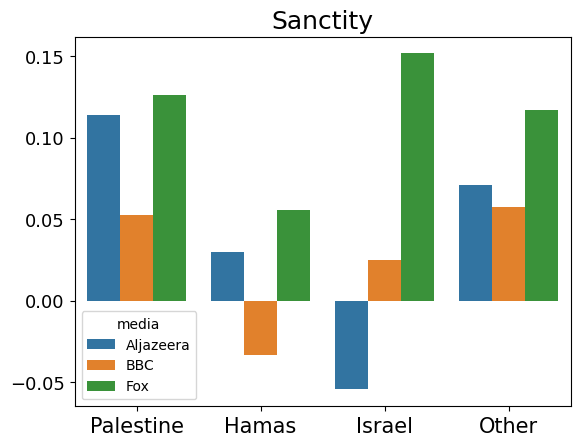

In [12]:
plot('sanctity')

In [13]:
def get_violin_plot_df(data, attr, entity):
    df = data[['media', attr]]
    df['entity'] = [entity] * df.shape[0]
    
    return df

In [14]:
no_entity_mentioned_df = data[data[['pal_ent', 'hamas_ent', 'isr_ent', 'other_ent']].eq(False).all(axis = 1)]
pal_entity_mentioned_df = data[data.pal_ent == True]
hamas_entity_mentioned_df = data[data.hamas_ent == True]
israel_entity_mentioned_df = data[data.isr_ent == True]
other_entity_mentioned_df = data[data.other_ent == True]
other_entity_mentioned_df_ = pd.concat((no_entity_mentioned_df, other_entity_mentioned_df), axis = 0)

In [15]:
attr = 'care'
df1 = get_violin_plot_df(pal_entity_mentioned_df, attr, 'Palestine')
df2 = get_violin_plot_df(hamas_entity_mentioned_df, attr, 'Hamas')
df3 = get_violin_plot_df(israel_entity_mentioned_df, attr, 'Israel')
df4 = get_violin_plot_df(other_entity_mentioned_df_, attr, 'Others')

/tmp/ipykernel_1861543/2330093117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['entity'] = [entity] * df.shape[0]


In [16]:
df = pd.concat((df1, df2, df3, df4), axis = 0)

In [17]:
df = df[df.media.isin(['aljazeera.com', 'foxnews.com'])]

Text(0.5, 1.0, 'CARE')

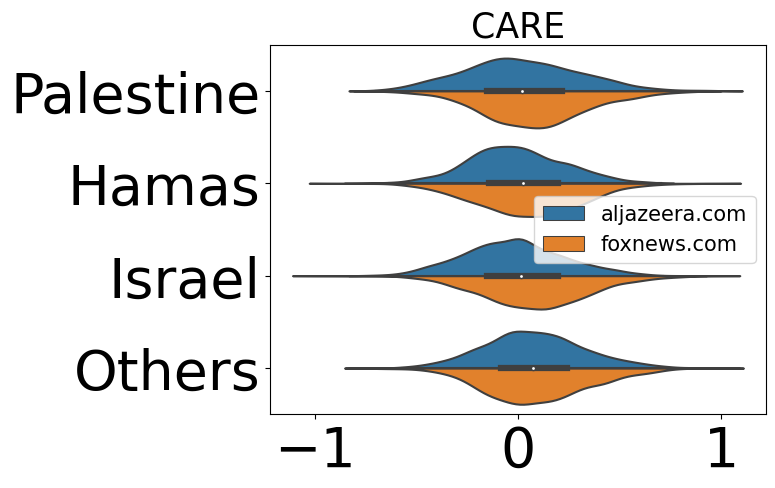

In [18]:
sns.set_context(rc={'xtick.labelsize': 40, 'ytick.labelsize': 40})
ax = sns.violinplot(data=df, x = attr, y = 'entity', hue = 'media', split=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.legend(fontsize=15)
ax.set_title(attr.upper(), fontsize = 25)